# **Setting Spark**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget --no-check-certificate \
    https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz \
    -O /content/spark-2.4.4-bin-hadoop2.7.tgz

--2020-12-23 13:46:42--  https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 2a01:4f8:10a:201a::2
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219929956 (210M) [application/x-gzip]
Saving to: ‘/content/spark-2.4.4-bin-hadoop2.7.tgz’

/content/spark-2.4. 100%[===================>] 209.74M  17.7MB/s    in 13s     

2020-12-23 13:46:56 (16.6 MB/s) - ‘/content/spark-2.4.4-bin-hadoop2.7.tgz’ saved [219929956/219929956]



In [ ]:
!tar xf spark-2.4.4-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 71kB/s 
     |████████████████████████████████| 204kB 50.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=ab251b9c3bee34ea5f08374de684edc3ace569f41ce8d46dbe40779e08bab515
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init("spark-3.0.1-bin-hadoop2.7")

In [ ]:
from pyspark import SparkContext
sparkContext = SparkContext.getOrCreate()

# **Input & Pre-Processing Data**

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
import pyspark

%matplotlib inline

print (sparkContext.version)

3.0.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Tugas ABD Distributed K-Means Clustering/
!ls

/content/drive/MyDrive/Tugas ABD Distributed K-Means Clustering
databersih.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = "databersih.csv"
df = pd.read_csv(data_dir)
df=df.drop('Organization Group',axis=1)
df=df.drop('Department',axis=1)
df=df.drop('Union',axis=1)
df=df.drop('Job Family',axis=1)
df=df.drop('Year Type',axis=1)
df=df.drop('Department Code',axis=1)
df=df.drop('Job',axis=1)
df=df.drop('retirement',axis=1)
df=df.drop('health and dental',axis=1)
df.head()

,Id,Year,Organization Group Code,Union Code,Job Family Code,Job Code,Employee Identifier,salaries,overtime,other salaries,total_salary,other benefits,total_benefits,total_compensation
0,0,2028,7,792,0,420C,8540990,674.28,0.0,5.76,680.04,53.86,184.77,864.81
1,1,2028,1,792,0,420C,8540990,674.28,0.0,5.76,680.04,53.86,184.77,864.81
2,2,2028,1,792,0,420C,8540990,674.28,0.0,5.76,680.04,53.86,184.77,864.81
3,7,2020,2,21,1600,1657,8580438,55912.50,0.0,0.00,55912.50,4342.10,22335.56,78248.06
4,37,2020,2,253,9100,9163,12020150,4160.00,0.0,0.00,4160.00,319.25,2752.27,6912.27


In [ ]:
# mengkonversi dataframe ke file csv
bytes_to_write = df.to_csv('input.csv')

In [ ]:
!ls

databersih.csv	input.csv


# **Read CSV to Spark data frame**

In [ ]:
data_dir = "input.csv"
data = pd.read_csv(data_dir)

In [ ]:
sqlContext = SQLContext(sparkContext)

In [ ]:
#FEATURES_COL = df.columns[1:].to_list()
FEATURES_COL = ['total_salary', 'total_benefits', 'total_compensation']
#path = 'input.csv'
path = 'drive/MyDrive/Tugas ABD Distributed K-Means Clustering/input.csv'

In [ ]:
data = sqlContext.read.csv(path, header=True) 
data.show()

+---+---+----+-----------------------+----------+---------------+--------+-------------------+--------+--------+--------------+------------+--------------+--------------+------------------+
|_c0| Id|Year|Organization Group Code|Union Code|Job Family Code|Job Code|Employee Identifier|salaries|overtime|other salaries|total_salary|other benefits|total_benefits|total_compensation|
+---+---+----+-----------------------+----------+---------------+--------+-------------------+--------+--------+--------------+------------+--------------+--------------+------------------+
|  0|  0|2028|                      7|       792|              0|    420C|            8540990|  674.28|     0.0|          5.76|      680.04|         53.86|        184.77|            864.81|
|  1|  1|2028|                      1|       792|              0|    420C|            8540990|  674.28|     0.0|          5.76|      680.04|         53.86|        184.77|            864.81|
|  2|  2|2028|                      1|       792| 

In [ ]:
lines = sparkContext.textFile(path)
data = lines.map(lambda line: line.split(","))
data.take(2)

[['',
  'Id',
  'Year',
  'Organization Group Code',
  'Union Code',
  'Job Family Code',
  'Job Code',
  'Employee Identifier',
  'salaries',
  'overtime',
  'other salaries',
  'total_salary',
  'other benefits',
  'total_benefits',
  'total_compensation'],
 ['0',
  '0',
  '2028',
  '7',
  '792',
  '0',
  '420C',
  '8540990',
  '674.28',
  '0.0',
  '5.76',
  '680.04',
  '53.86',
  '184.77',
  '864.81']]

In [ ]:
df = data.toDF(['id', 'total_salary', 'total_benefits', 'total_compensation'])
print (df)
df.show()

DataFrame[id: string, total_salary: string, total_benefits: string, total_compensation: string, _5: string, _6: string, _7: string, _8: string, _9: string, _10: string, _11: string, _12: string, _13: string, _14: string, _15: string]
+---+------------+--------------+--------------------+----------+---------------+--------+-------------------+--------+--------+--------------+------------+--------------+--------------+------------------+
| id|total_salary|total_benefits|  total_compensation|        _5|             _6|      _7|                 _8|      _9|     _10|           _11|         _12|           _13|           _14|               _15|
+---+------------+--------------+--------------------+----------+---------------+--------+-------------------+--------+--------+--------------+------------+--------------+--------------+------------------+
|   |          Id|          Year|Organization Grou...|Union Code|Job Family Code|Job Code|Employee Identifier|salaries|overtime|other salaries|total

# **Convert data (toFloat)**

In [ ]:
df_feat = df.select(*(df[c].cast("float").alias(c) for c in df.columns[1:]))
df_feat.show()

+------------+--------------+------------------+-----+------+------+-----------+--------+-------+-------+--------+-------+--------+---------+
|total_salary|total_benefits|total_compensation|   _5|    _6|    _7|         _8|      _9|    _10|    _11|     _12|    _13|     _14|      _15|
+------------+--------------+------------------+-----+------+------+-----------+--------+-------+-------+--------+-------+--------+---------+
|        null|          null|              null| null|  null|  null|       null|    null|   null|   null|    null|   null|    null|     null|
|         0.0|        2028.0|               7.0|792.0|   0.0|  null|  8540990.0|  674.28|    0.0|   5.76|  680.04|  53.86|  184.77|   864.81|
|         1.0|        2028.0|               1.0|792.0|   0.0|  null|  8540990.0|  674.28|    0.0|   5.76|  680.04|  53.86|  184.77|   864.81|
|         2.0|        2028.0|               1.0|792.0|   0.0|  null|  8540990.0|  674.28|    0.0|   5.76|  680.04|  53.86|  184.77|   864.81|
|     

In [ ]:
for col in df.columns:
    if col in FEATURES_COL:
        df = df.withColumn(col,df[col].cast('float'))
df.show()

+---+------------+--------------+------------------+----------+---------------+--------+-------------------+--------+--------+--------------+------------+--------------+--------------+------------------+
| id|total_salary|total_benefits|total_compensation|        _5|             _6|      _7|                 _8|      _9|     _10|           _11|         _12|           _13|           _14|               _15|
+---+------------+--------------+------------------+----------+---------------+--------+-------------------+--------+--------+--------------+------------+--------------+--------------+------------------+
|   |        null|          null|              null|Union Code|Job Family Code|Job Code|Employee Identifier|salaries|overtime|other salaries|total_salary|other benefits|total_benefits|total_compensation|
|  0|         0.0|        2028.0|               7.0|       792|              0|    420C|            8540990|  674.28|     0.0|          5.76|      680.04|         53.86|        184.77|

# **Drop Null Value**

In [ ]:
df = df.na.drop()
df.show()

+---+------------+--------------+------------------+---+----+----+--------+--------+-------+-------+--------+-------+--------+---------+
| id|total_salary|total_benefits|total_compensation| _5|  _6|  _7|      _8|      _9|    _10|    _11|     _12|    _13|     _14|      _15|
+---+------------+--------------+------------------+---+----+----+--------+--------+-------+-------+--------+-------+--------+---------+
|  0|         0.0|        2028.0|               7.0|792|   0|420C| 8540990|  674.28|    0.0|   5.76|  680.04|  53.86|  184.77|   864.81|
|  1|         1.0|        2028.0|               1.0|792|   0|420C| 8540990|  674.28|    0.0|   5.76|  680.04|  53.86|  184.77|   864.81|
|  2|         2.0|        2028.0|               1.0|792|   0|420C| 8540990|  674.28|    0.0|   5.76|  680.04|  53.86|  184.77|   864.81|
|  3|         7.0|        2020.0|               2.0| 21|1600|1657| 8580438| 55912.5|    0.0|    0.0| 55912.5| 4342.1|22335.56| 78248.06|
|  4|        37.0|        2020.0|        

# **Create Feature for Clustering**

In [ ]:
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df).select('Id', 'features')
df_kmeans.show()

+---+------------------+
| Id|          features|
+---+------------------+
|  0|  [0.0,2028.0,7.0]|
|  1|  [1.0,2028.0,1.0]|
|  2|  [2.0,2028.0,1.0]|
|  3|  [7.0,2020.0,2.0]|
|  4| [37.0,2020.0,2.0]|
|  5| [58.0,2020.0,2.0]|
|  6| [61.0,2020.0,6.0]|
|  7| [69.0,2020.0,5.0]|
|  8| [71.0,2020.0,2.0]|
|  9| [78.0,2020.0,2.0]|
| 10| [80.0,2020.0,6.0]|
| 11|[100.0,2020.0,4.0]|
| 12|[102.0,2020.0,5.0]|
| 13|[117.0,2020.0,4.0]|
| 14|[141.0,2020.0,2.0]|
| 15|[148.0,2020.0,2.0]|
| 16|[158.0,2020.0,4.0]|
| 17|[163.0,2020.0,1.0]|
| 18|[164.0,2020.0,4.0]|
| 19|[205.0,2020.0,6.0]|
+---+------------------+
only showing top 20 rows



# **Optimize valiabel 'K'**

In [ ]:
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

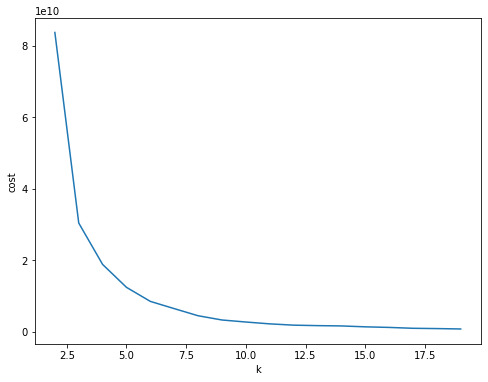

In [ ]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

# **Train Model K-Means**

In [ ]:
k = 17
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[3.88102520e+04 2.02000000e+03 2.89403384e+00]
[7.27818e+03 2.02000e+03 3.17000e+00]
[4.85249454e+04 2.01900000e+03 4.99304441e+00]
[2.58393080e+04 2.02000000e+03 2.90736342e+00]
[3.21644134e+04 2.02000000e+03 2.88299532e+00]
[1.51907083e+04 2.02000000e+03 2.95208333e+00]
[2.13895777e+04 2.02000000e+03 2.99419954e+00]
[5.05613864e+04 2.01900000e+03 4.97047497e+00]
[4.64670963e+04 2.01900000e+03 4.91415193e+00]
[3.54148260e+04 2.02000000e+03 2.90847458e+00]
[4.16259420e+03 2.02000000e+03 3.04830918e+00]
[1.05024650e+04 2.02000000e+03 3.06427221e+00]
[4.20033142e+04 2.01920585e+03 4.54644495e+00]
[1395.97472924 2020.0866426     2.97111913]
[2.91655117e+04 2.02000000e+03 3.02333621e+00]
[4.4347810e+04 2.0190000e+03 4.9366613e+00]
[1.26464963e+04 2.02000000e+03 2.92647059e+00]


# **Assign Cluster**

In [ ]:
transformed = model.transform(df_kmeans).select('Id', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(Id='0', prediction=13), Row(Id='1', prediction=13), Row(Id='2', prediction=13)]


In [ ]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+---+----------+
| Id|prediction|
+---+----------+
|  0|        13|
|  1|        13|
|  2|        13|
|  3|        13|
|  4|        13|
|  5|        13|
|  6|        13|
|  7|        13|
|  8|        13|
|  9|        13|
| 10|        13|
| 11|        13|
| 12|        13|
| 13|        13|
| 14|        13|
| 15|        13|
| 16|        13|
| 17|        13|
| 18|        13|
| 19|        13|
+---+----------+
only showing top 20 rows



# **Join prediction result + original data**

In [ ]:
df_pred = df_pred.join(df,'Id')
df_pred.show()

+-----+----------+------------+--------------+------------------+---+----+----+--------+---------+--------+--------+---------+--------+--------+---------+
|   Id|prediction|total_salary|total_benefits|total_compensation| _5|  _6|  _7|      _8|       _9|     _10|     _11|      _12|     _13|     _14|      _15|
+-----+----------+------------+--------------+------------------+---+----+----+--------+---------+--------+--------+---------+--------+--------+---------+
|10096|        12|     42701.0|        2019.0|               7.0|791|2300|2320| 8567133|143593.01|     0.0|  291.52|143884.53|10640.27|67414.08|211298.61|
|10351|        12|     43050.0|        2019.0|               2.0|130|7300|7381| 8588819| 34728.78|    0.67|     0.0| 34729.45| 3617.67| 25740.5| 60469.95|
|10436|        12|     43167.0|        2019.0|               1.0|798|H000|H003| 8493090| 82723.04| 7771.93| 4794.62| 95289.59| 1593.24|45538.98|140828.57|
| 1090|        11|     11321.0|        2020.0|               1.0|790|8

# **Converto to Data frame**

In [ ]:
pddf_pred = df_pred.toPandas().set_index('Id')
pddf_pred.head()

,prediction,total_salary,total_benefits,total_compensation,_5,_6,_7,_8,_9,_10,_11,_12,_13,_14,_15
Id,,,,,,,,,,,,,,,
10096,12,42701.0,2019.0,7.0,791,2300,2320,8567133,143593.01,0.0,291.52,143884.53,10640.27,67414.08,211298.61
10351,12,43050.0,2019.0,2.0,130,7300,7381,8588819,34728.78,0.67,0.0,34729.45,3617.67,25740.5,60469.95
10436,12,43167.0,2019.0,1.0,798,H000,H003,8493090,82723.04,7771.93,4794.62,95289.59,1593.24,45538.98,140828.57
1090,11,11321.0,2020.0,1.0,790,8200,8238,8535260,44108.35,22788.15,710.02,67606.52,5228.45,21222.86,88829.38
11078,15,43998.0,2019.0,4.0,21,1000,1041,8503383,107559.61,0.0,0.0,107559.61,8367.47,58384.76,165944.37


# **Visualisasi**

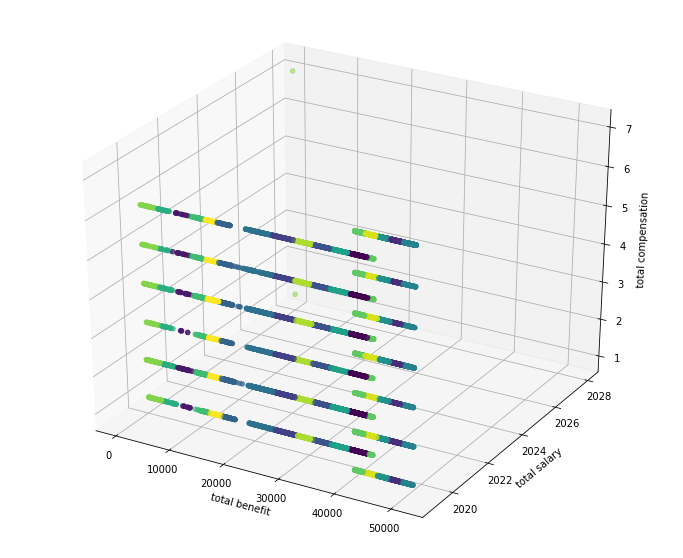

In [ ]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(pddf_pred.total_salary, pddf_pred.total_benefits, pddf_pred.total_compensation, c=pddf_pred.prediction)
threedee.set_xlabel('total benefit')
threedee.set_ylabel('total salary')
threedee.set_zlabel('total compensation')
plt.show()